# Dataset Analysis: Chest X-Ray Pneumonia Detection

This notebook provides comprehensive statistical analysis and visualization of the training, validation, and test datasets.

## Contents
1. Data Loading & Overview
2. Class Distribution Analysis
3. Image Statistics
4. Pixel Intensity Analysis
5. Dataset Comparison
6. Sample Visualization
7. Data Quality Checks
8. Summary Report

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Create figures directory
os.makedirs('figures', exist_ok=True)

print('Libraries loaded successfully!')

Libraries loaded successfully!


## 1. Data Loading & Overview

In [2]:
def resolve_data_path(data_dir):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')
    
    normal_paths = [os.path.join(data_dir, 'NORMAL', f) 
                    for f in os.listdir(normal_dir) 
                    if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    
    pneumonia_paths = [os.path.join(data_dir, 'PNEUMONIA', f) 
                       for f in os.listdir(pneumonia_dir) 
                       if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    
    paths = normal_paths + pneumonia_paths
    labels = [0] * len(normal_paths) + [1] * len(pneumonia_paths)
    class_names = ['Normal'] * len(normal_paths) + ['Pneumonia'] * len(pneumonia_paths)
    
    return pd.DataFrame({'path': paths, 'label': labels, 'class_name': class_names})

# Load datasets
print('Loading datasets...')
train_val_df = resolve_data_path('datasets/train_val')
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)
test_df = resolve_data_path('datasets/test')

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f'Train set: {len(train_df)} images')
print(f'Validation set: {len(val_df)} images')
print(f'Test set: {len(test_df)} images')
print(f'Total: {len(train_df) + len(val_df) + len(test_df)} images')

Loading datasets...
Train set: 4185 images
Validation set: 1047 images
Test set: 624 images
Total: 5856 images


In [3]:
# Dataset Overview Table
def create_overview_table(train_df, val_df, test_df):
    datasets = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
    overview = []
    for name, df in datasets.items():
        normal_count = len(df[df['label'] == 0])
        pneumonia_count = len(df[df['label'] == 1])
        total = len(df)
        overview.append({
            'Dataset': name,
            'Total': total,
            'Normal': normal_count,
            'Pneumonia': pneumonia_count,
            'Normal %': f'{normal_count/total*100:.1f}%',
            'Pneumonia %': f'{pneumonia_count/total*100:.1f}%',
            'Ratio': f'1:{pneumonia_count/normal_count:.2f}'
        })
    return pd.DataFrame(overview)

overview_table = create_overview_table(train_df, val_df, test_df)
print('\nDATASET OVERVIEW')
print('='*60)
display(overview_table)


DATASET OVERVIEW


,Dataset,Total,Normal,Pneumonia,Normal %,Pneumonia %,Ratio
0,Train,4185,1079,3106,25.8%,74.2%,1:2.88
1,Validation,1047,270,777,25.8%,74.2%,1:2.88
2,Test,624,234,390,37.5%,62.5%,1:1.67


## 2. Class Distribution Analysis

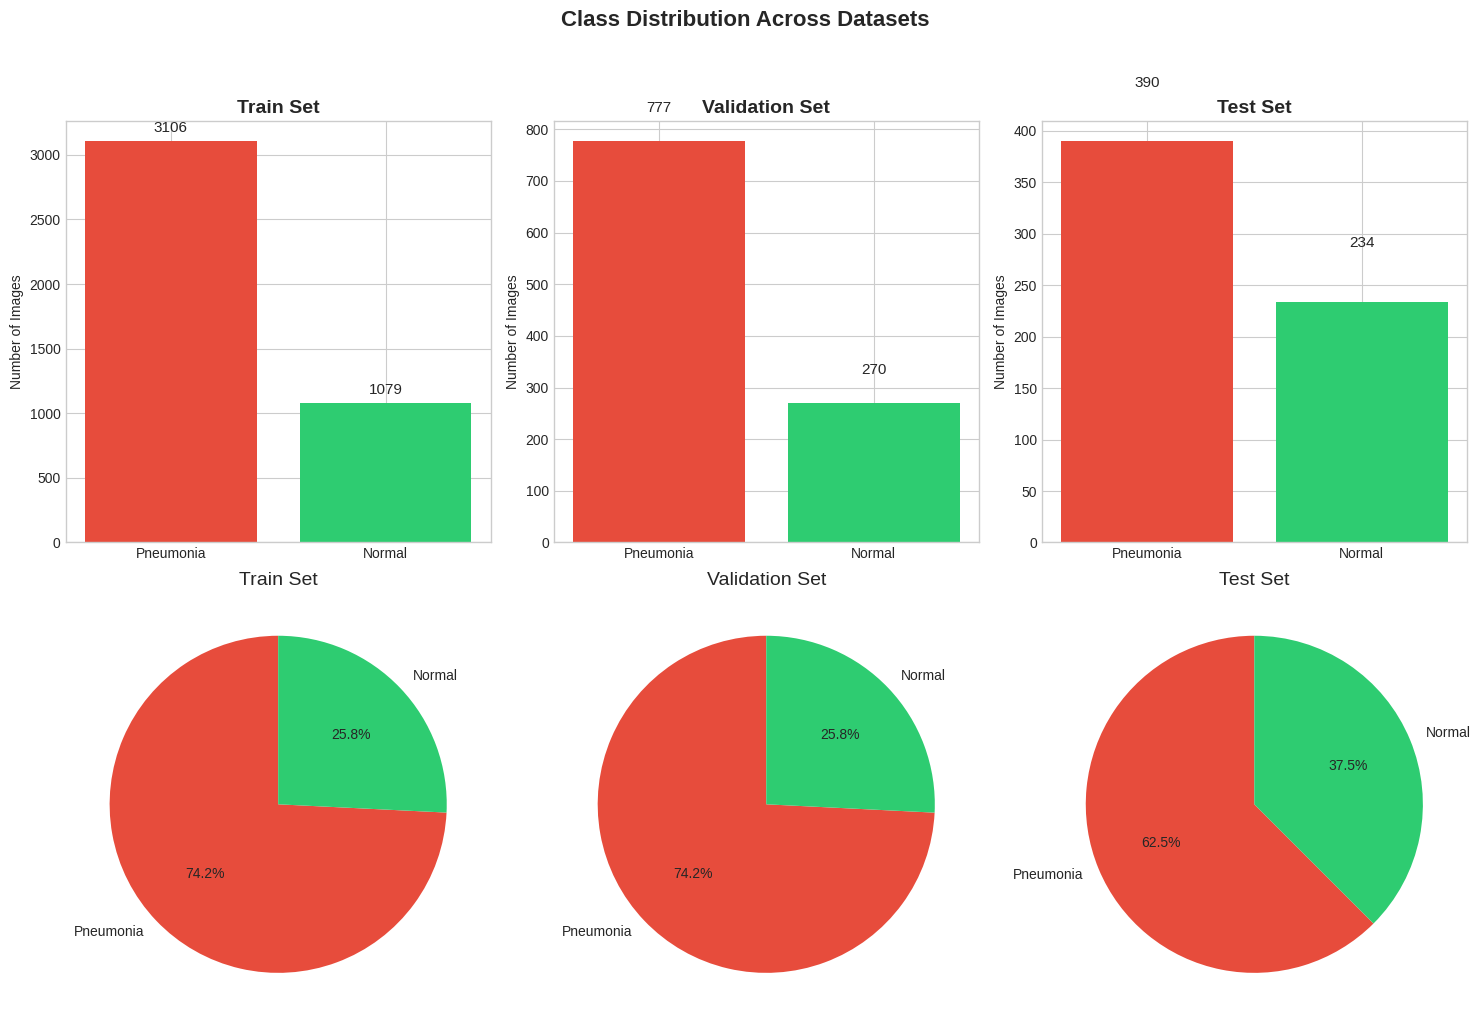

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
datasets = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
colors = {'Normal': '#2ecc71', 'Pneumonia': '#e74c3c'}

# Bar charts
for idx, (name, df) in enumerate(datasets.items()):
    ax = axes[0, idx]
    counts = df['class_name'].value_counts()
    bars = ax.bar(counts.index, counts.values, color=[colors[c] for c in counts.index])
    ax.set_title(f'{name} Set', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Images')
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count}', ha='center', va='bottom', fontsize=11)

# Pie charts
for idx, (name, df) in enumerate(datasets.items()):
    ax = axes[1, idx]
    counts = df['class_name'].value_counts()
    ax.pie(counts.values, labels=counts.index, colors=[colors[c] for c in counts.index],
           autopct='%1.1f%%', startangle=90)
    ax.set_title(f'{name} Set', fontsize=14)

plt.suptitle('Class Distribution Across Datasets', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

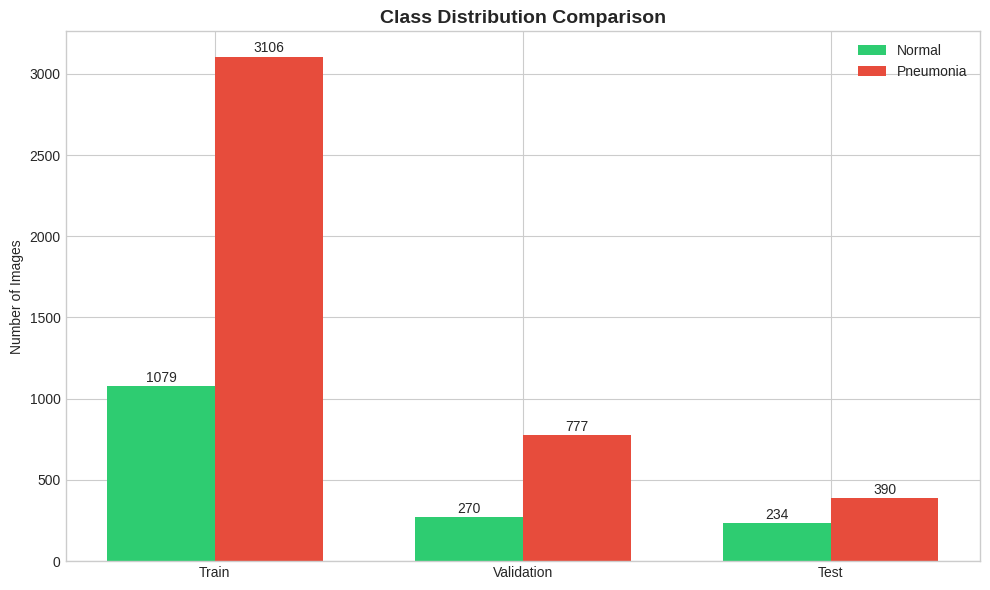

In [5]:
# Grouped Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
dataset_names = ['Train', 'Validation', 'Test']
normal_counts = [len(train_df[train_df['label']==0]), len(val_df[val_df['label']==0]), len(test_df[test_df['label']==0])]
pneumonia_counts = [len(train_df[train_df['label']==1]), len(val_df[val_df['label']==1]), len(test_df[test_df['label']==1])]

x = np.arange(len(dataset_names))
width = 0.35
bars1 = ax.bar(x - width/2, normal_counts, width, label='Normal', color='#2ecc71')
bars2 = ax.bar(x + width/2, pneumonia_counts, width, label='Pneumonia', color='#e74c3c')

ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dataset_names)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/class_comparison.png', dpi=150)
plt.show()

In [6]:
# Class Imbalance Analysis
print('\nCLASS IMBALANCE ANALYSIS')
print('='*60)
for name, df in datasets.items():
    normal = len(df[df['label'] == 0])
    pneumonia = len(df[df['label'] == 1])
    total = normal + pneumonia
    weight_normal = total / (2 * normal)
    weight_pneumonia = total / (2 * pneumonia)
    print(f'\n{name}:')
    print(f'  Normal: {normal} ({normal/total*100:.1f}%)')
    print(f'  Pneumonia: {pneumonia} ({pneumonia/total*100:.1f}%)')
    print(f'  Suggested Weights: Normal={weight_normal:.3f}, Pneumonia={weight_pneumonia:.3f}')


CLASS IMBALANCE ANALYSIS

Train:
  Normal: 1079 (25.8%)
  Pneumonia: 3106 (74.2%)
  Suggested Weights: Normal=1.939, Pneumonia=0.674

Validation:
  Normal: 270 (25.8%)
  Pneumonia: 777 (74.2%)
  Suggested Weights: Normal=1.939, Pneumonia=0.674

Test:
  Normal: 234 (37.5%)
  Pneumonia: 390 (62.5%)
  Suggested Weights: Normal=1.333, Pneumonia=0.800


## 3. Image Statistics

In [7]:
def analyze_dimensions(df, name, sample_size=None):
    paths = df['path'].tolist()
    if sample_size and sample_size < len(paths):
        paths = np.random.choice(paths, sample_size, replace=False)
    
    widths, heights, file_sizes = [], [], []
    for path in tqdm(paths, desc=f'Analyzing {name}'):
        try:
            img = Image.open(path)
            widths.append(img.size[0])
            heights.append(img.size[1])
            file_sizes.append(os.path.getsize(path) / 1024)
        except: pass
    return pd.DataFrame({'width': widths, 'height': heights, 'file_size_kb': file_sizes})

train_dims = analyze_dimensions(train_df, 'Train')
val_dims = analyze_dimensions(val_df, 'Validation')
test_dims = analyze_dimensions(test_df, 'Test')
print('Dimension analysis complete!')

Analyzing Test: 100%|██████████| 624/624 [00:00<00:00, 9736.85it/s]

Dimension analysis complete!


In [8]:
# Dimension Statistics
dims_dict = {'Train': train_dims, 'Validation': val_dims, 'Test': test_dims}
stats = []
for name, dims in dims_dict.items():
    stats.append({
        'Dataset': name,
        'Width (min-max)': f"{dims['width'].min()}-{dims['width'].max()}",
        'Width (mean)': f"{dims['width'].mean():.0f}",
        'Height (min-max)': f"{dims['height'].min()}-{dims['height'].max()}",
        'Height (mean)': f"{dims['height'].mean():.0f}",
        'File Size (KB)': f"{dims['file_size_kb'].mean():.1f}"
    })
print('\nIMAGE DIMENSION STATISTICS')
display(pd.DataFrame(stats))


IMAGE DIMENSION STATISTICS


,Dataset,Width (min-max),Width (mean),Height (min-max),Height (mean),File Size (KB)
0,Train,384-2916,1318,127-2663,966,215.9
1,Validation,437-2772,1333,144-2625,977,216.5
2,Test,728-2752,1388,344-2713,992,123.7


In [ ]:
# Dimension Distribution Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for name, dims in dims_dict.items():
    axes[0,0].hist(dims['width'], bins=30, alpha=0.5, label=name)
axes[0,0].set_xlabel('Width (pixels)')
axes[0,0].set_title('Width Distribution')
axes[0,0].legend()

for name, dims in dims_dict.items():
    axes[0,1].hist(dims['height'], bins=30, alpha=0.5, label=name)
axes[0,1].set_xlabel('Height (pixels)')
axes[0,1].set_title('Height Distribution')
axes[0,1].legend()

colors_map = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}
for name, dims in dims_dict.items():
    axes[1,0].scatter(dims['width'], dims['height'], alpha=0.3, label=name, s=10, c=colors_map[name])
axes[1,0].set_xlabel('Width')
axes[1,0].set_ylabel('Height')
axes[1,0].set_title('Width vs Height')
axes[1,0].legend()

for name, dims in dims_dict.items():
    axes[1,1].hist(dims['file_size_kb'], bins=30, alpha=0.5, label=name)
axes[1,1].set_xlabel('File Size (KB)')
axes[1,1].set_title('File Size Distribution')
axes[1,1].legend()

plt.suptitle('Image Dimension Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/dimension_analysis.png', dpi=150)
plt.show()

## 4. Pixel Intensity Analysis

In [ ]:
def analyze_intensity(df, name, sample_size=100):
    sample = df.sample(min(sample_size, len(df)))
    stats = []
    for _, row in tqdm(sample.iterrows(), total=len(sample), desc=f'Intensity {name}'):
        try:
            img = np.array(Image.open(row['path']).convert('L'))
            stats.append({'mean': img.mean(), 'std': img.std(), 'label': row['label']})
        except: pass
    return pd.DataFrame(stats)

train_intensity = analyze_intensity(train_df, 'Train', 200)
val_intensity = analyze_intensity(val_df, 'Val', 100)
test_intensity = analyze_intensity(test_df, 'Test', 100)

In [ ]:
# Intensity by Class
all_intensity = pd.concat([train_intensity.assign(dataset='Train'),
                           val_intensity.assign(dataset='Val'),
                           test_intensity.assign(dataset='Test')])
all_intensity['class_name'] = all_intensity['label'].map({0: 'Normal', 1: 'Pneumonia'})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=all_intensity, x='class_name', y='mean', hue='dataset', ax=axes[0])
axes[0].set_title('Mean Pixel Intensity by Class')
sns.boxplot(data=all_intensity, x='class_name', y='std', hue='dataset', ax=axes[1])
axes[1].set_title('Pixel Intensity Std by Class')
plt.tight_layout()
plt.savefig('figures/pixel_intensity.png', dpi=150)
plt.show()

## 5. Dataset Comparison

In [ ]:
from scipy import stats as scipy_stats

# Chi-square test for class distribution
contingency = pd.DataFrame({
    'Train': [len(train_df[train_df['label']==0]), len(train_df[train_df['label']==1])],
    'Val': [len(val_df[val_df['label']==0]), len(val_df[val_df['label']==1])],
    'Test': [len(test_df[test_df['label']==0]), len(test_df[test_df['label']==1])]
}, index=['Normal', 'Pneumonia'])

print('\nCHI-SQUARE TEST FOR CLASS DISTRIBUTION')
print('='*50)
display(contingency)

chi2, p_value, dof, expected = scipy_stats.chi2_contingency(contingency.values)
print(f'\nChi-square: {chi2:.4f}, p-value: {p_value:.4f}')
if p_value < 0.05:
    print('Result: Distributions are SIGNIFICANTLY DIFFERENT (p < 0.05)')
else:
    print('Result: Distributions are SIMILAR (p >= 0.05)')

## 6. Sample Visualization

In [ ]:
def plot_samples(df, title, n=5):
    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
    for row, (label, name) in enumerate([(0, 'Normal'), (1, 'Pneumonia')]):
        samples = df[df['label']==label].sample(min(n, len(df[df['label']==label])))
        for col, (_, r) in enumerate(samples.iterrows()):
            if col >= n: break
            img = Image.open(r['path'])
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(f'{name}\n{img.size[0]}x{img.size[1]}')
            axes[row, col].axis('off')
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

plot_samples(train_df, 'Train Set Samples')
plt.savefig('figures/train_samples.png', dpi=150)
plt.show()

plot_samples(test_df, 'Test Set Samples')
plt.savefig('figures/test_samples.png', dpi=150)
plt.show()

In [ ]:
# Average Images per Class
def compute_average(df, label, n=100, size=(224,224)):
    samples = df[df['label']==label].sample(min(n, len(df[df['label']==label])))
    images = [np.array(Image.open(r['path']).convert('L').resize(size)) for _, r in samples.iterrows()]
    return np.mean(images, axis=0)

avg_normal = compute_average(train_df, 0)
avg_pneumonia = compute_average(train_df, 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(avg_normal, cmap='gray')
axes[0].set_title('Average Normal')
axes[0].axis('off')

axes[1].imshow(avg_pneumonia, cmap='gray')
axes[1].set_title('Average Pneumonia')
axes[1].axis('off')

diff = avg_pneumonia - avg_normal
axes[2].imshow(diff, cmap='RdBu_r', vmin=-50, vmax=50)
axes[2].set_title('Difference (P-N)')
axes[2].axis('off')

plt.suptitle('Average Images by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/average_images.png', dpi=150)
plt.show()

## 7. Data Quality Checks

In [ ]:
print('\nDATA QUALITY CHECKS')
print('='*50)

for name, df in datasets.items():
    print(f'\n{name}:')
    print(f'  Duplicates: {df["path"].duplicated().sum()}')
    print(f'  Missing files: {sum(1 for p in df["path"] if not os.path.exists(p))}')
    exts = Counter(os.path.splitext(p)[1].lower() for p in df['path'])
    print(f'  Extensions: {dict(exts)}')

In [ ]:
# Data Leakage Check
print('\nDATA LEAKAGE CHECK')
print('='*50)
train_files = set(os.path.basename(p) for p in train_df['path'])
val_files = set(os.path.basename(p) for p in val_df['path'])
test_files = set(os.path.basename(p) for p in test_df['path'])

print(f'Train-Val overlap: {len(train_files & val_files)}')
print(f'Train-Test overlap: {len(train_files & test_files)}')
print(f'Val-Test overlap: {len(val_files & test_files)}')

if len(train_files & test_files) == 0:
    print('\nNo data leakage detected!')

## 8. Summary Report

In [ ]:
total = len(train_df) + len(val_df) + len(test_df)
total_normal = sum(len(df[df['label']==0]) for df in [train_df, val_df, test_df])
total_pneumonia = sum(len(df[df['label']==1]) for df in [train_df, val_df, test_df])

print('\n' + '='*60)
print('DATASET ANALYSIS SUMMARY')
print('='*60)
print(f'''
OVERVIEW
--------
Total Images: {total:,}
  - Train:      {len(train_df):,} ({len(train_df)/total*100:.1f}%)
  - Validation: {len(val_df):,} ({len(val_df)/total*100:.1f}%)
  - Test:       {len(test_df):,} ({len(test_df)/total*100:.1f}%)

CLASS DISTRIBUTION
------------------
Normal:    {total_normal:,} ({total_normal/total*100:.1f}%)
Pneumonia: {total_pneumonia:,} ({total_pneumonia/total*100:.1f}%)
Ratio:     1:{total_pneumonia/total_normal:.2f}

KEY FINDINGS
------------
- Dataset is IMBALANCED (more Pneumonia)
- Use class weights or oversampling
- Image sizes vary - resize to 224x224
- No data leakage detected
''')